### Imports

In [3]:
# Use for testing

import pandas as pd
from pandas.api.types import CategoricalDtype

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import seaborn as sn

import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [5]:
#Import country names, codes and regions
df = pd.read_csv('../Data/Raw/CountriesNames.csv', sep=';')
df = df.rename(columns={'continent' : 'cntry_region','name':'cntry_name','code':'cntry_code'})

#Cleaning the countries dataframe, exclusing the antarctic regions
cntry_df = df[df['cntry_region']!='Antarctica North']
cntry_df = cntry_df.sort_values('cntry_name')
#cntry_df['cntry_name'].unique()

### Cleaning Functions

In [6]:
def EnergyProduction():
    #Inputing the data
    df = pd.read_csv('../Data/Raw/EnergyProduction.csv')
    df_countries = pd.read_csv('../Data/Raw/CountriesNames.csv', sep=';')
    df_countries = df_countries.rename(columns={'continent' : 'cntry_region','name':'cntry_name','code':'cntry_code'})

    df_countries = df_countries[df_countries['cntry_region']!='Antarctica North']

    df = df.rename(str.lower, axis='columns')
    df = df.rename(columns={'flag codes' : 'flag_codes'})
    df = df.fillna(0)

    df['time'] = pd.to_datetime(df['time'], format="%Y")
    df['year'] = df['time'].dt.year
    
    df = df[df['measure']=='KTOE']

    #Deleting the L values rows
    dfl = df[df['flag_codes']!='L'] 
    dfl = dfl.drop(columns=['flag_codes'])

    merged_df = pd.merge(dfl, df_countries, left_on='location', right_on='cntry_code', how='left')


    codes_todrop = ['WLD','EU28','OECD','G20','OEU']
    merged_df = merged_df[~merged_df['location'].isin(codes_todrop)]


    merged_df = merged_df[['time','year','cntry_code','cntry_name','cntry_region','measure','subject','value']]

    reg_cont = ['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America']
    reg_type = CategoricalDtype(categories=reg_cont, ordered=False)
    merged_df['cntry_region'] = merged_df['cntry_region'].astype(reg_type)

    return merged_df


In [9]:
def CountriesGDP():
    
    df = pd.read_csv('../Data/Raw/CountriesGDP.csv')

    df_countries = pd.read_csv('../Data/Raw/CountriesNames.csv', sep=';')
    df_countries = df_countries.rename(columns={'continent' : 'cntry_region','name':'cntry_name','code':'cntry_code'})
    
    df = df.sort_values('year')
    df = df[df['year'] <= 2015]
    df = df[['country_code','year','value']]

    df = df.rename(columns={'country_code':'cntry_code','year':'year','value':'gpd'})
    gpd_df = df[df['cntry_code'].isin(df_countries['cntry_code'].unique())]

    #Merge the GDP DataFrame and the Country DataFrame
    gpd_df = gpd_df.merge(df_countries, how='inner')
    gpd_df = gpd_df[['cntry_code','cntry_name','cntry_region','year','gpd']]
    
    return gpd_df

### Testing Cells

In [10]:
#Defining the DataFrames
energy_df = EnergyProduction()
gdp_df = CountriesGDP()

In [11]:
energy_df = energy_df[['time','year','cntry_code','cntry_name','cntry_region','value']]
merged_df = energy_df.merge(gdp_df, how='inner')\
    .sort_values('cntry_name')

merged_df['corr'] = merged_df['value'] / (merged_df['gpd']/1000000)

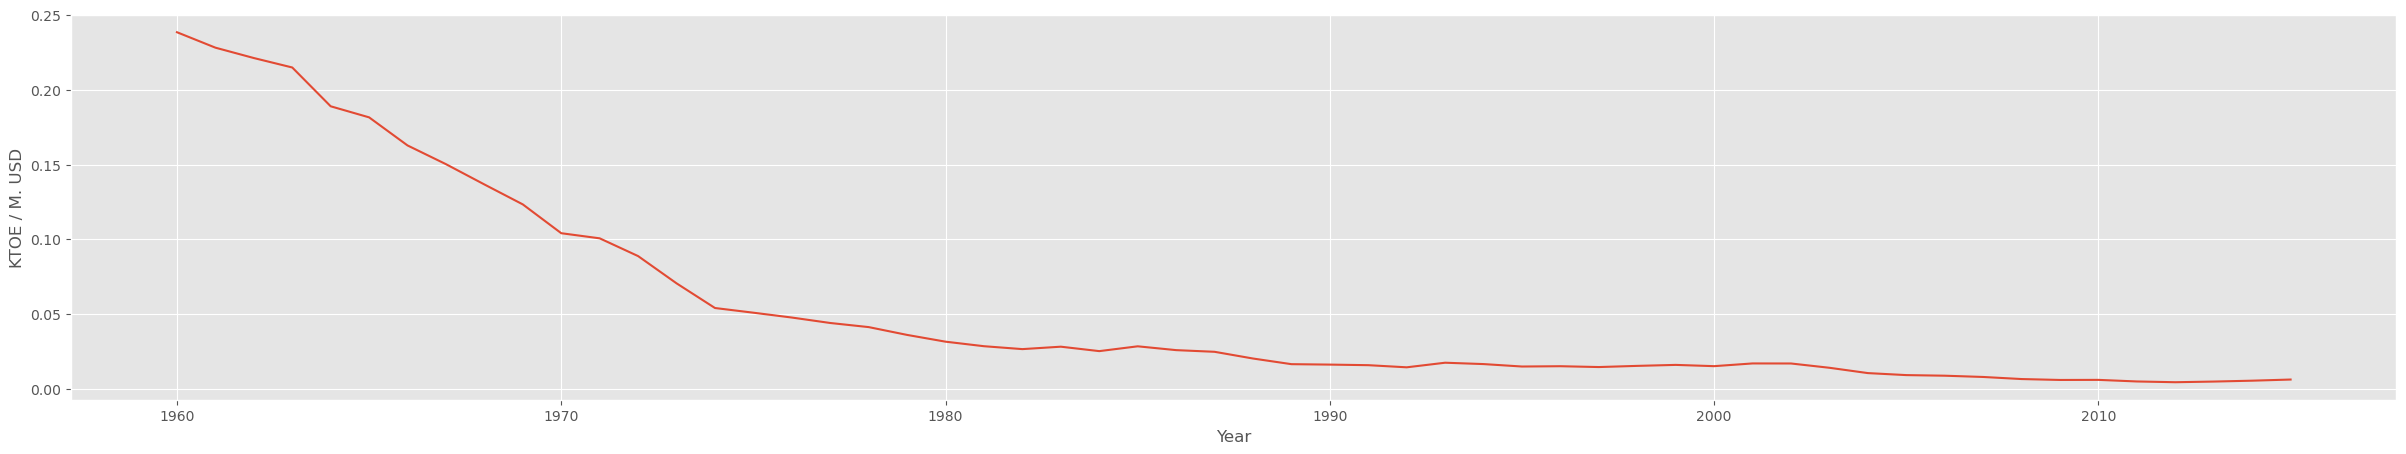

In [12]:
#Filteting the df
filtered_df = merged_df[merged_df['cntry_code']=='AUS']
filtered_df = filtered_df.sort_values('year')

#Ploting the sum from North America
fig, ax = plt.subplots(figsize=(30,5))
#sn.barplot(data=df_cntry,x=df_cntry.index,y='value',ax=ax, alpha=.5,color='blue')
sn.lineplot(data=filtered_df,x='year',y='corr',ax=ax)
#sn.relplot(x="cntry_code", y="value", hue="cntry_region", size="year",sizes=(20,30), alpha=.5, palette="muted", height=6, data=dfp)


ax.set_xlabel('Year')
ax.set_ylabel('KTOE / M. USD')
plt.show()
